In [ ]:
import pandas as pd 
import numpy as np 
import os


import matplotlib.pyplot as plt

# we use tensorflow to create our neural network for this experiment 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

# import the preprocessing functions we've made 
%cd '/content/gdrive/Shared drives/PFE/Colab Notebooks'

import preprocess

%cd '/content/gdrive/Shared drives/PFE/Colab Notebooks/Task 2/scarcity'


Mounted at /content/gdrive
/content/gdrive/Shared drives/PFE/Colab Notebooks
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/content/gdrive/Shared drives/PFE/Colab Notebooks/Task 2/scarcity


In [ ]:
dataset = pd.read_csv('./data/revised/training_scarcity_18k.csv') 
dataset=dataset.sample(frac=1)

In [ ]:
import re 
# Functions for removing contractions 
contraction_dict = {"you'll":"you will", "we're": "we are","ain't": "are not","'s":" is","aren't": "are not", "won't": "would not", "don't": "do not", "isn't": "is not", "it's" : "it is"}
def expand_contractions(data,contractions_dict = contraction_dict):
  '''
    Expanding Contractions
    Arguments:
      data: textual dataset 
      contractions_dict : dictionanary containing the contractions and their replacements 
    Returns :
      clean_data : textual dataset where contractions are expanded
  '''
  # Regular expression for finding contractions
  contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
  def replace(match):
      return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, data)

In [ ]:
import string 

dataset['ad'] = dataset['ad'].str.strip().str.lower() 

# Expand contractions 
dataset['ad'] = dataset['ad'].apply(lambda x:expand_contractions(x))

# Remove ponctuation 
dataset['ad'] =  dataset['ad'].str.translate(str.maketrans('','',string.punctuation))

dataset

,ad,scarcity
13943,new podcast episode with shannon watts of moms...,0
8286,we are ready to turn the moment into a movemen...,1
5101,breaking the trump administration just ripped ...,1
2770,let is see how powerful social media really is...,1
3226,im running for lake county treasurer because i...,1
...,...,...
12020,moorhead news lewis lawsuit claims walz is cor...,0
7723,the megafires are multiplying around the world...,1
177,i need your support right now gop dark money g...,1
3305,it is time to axthebevtax,1


In [ ]:
# build test and training datasets 
train_data, test_data = preprocess.eval_train_split(dataset['ad'], dataset['scarcity'] , test_size = 0.2, validation = False)
norm_train, y_train, norm_test, y_test = train_data[0], train_data[1], test_data[0], test_data[1]

In [ ]:
# data tokenization 
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')

# fit the tokenizer on the training documents
t.fit_on_texts(norm_train)
t.word_index['<PAD>'] = 0
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('workforces', 38717), ('<PAD>', 0), 1)

In [ ]:
# create tokenized data sequences to feed to the neural network 
train_sequences = t.texts_to_sequences(norm_train.values.astype('U'))
test_sequences = t.texts_to_sequences(norm_test.values.astype('U'))

In [ ]:
MAX_SEQUENCE_LENGTH = 1000

# pad documents to equal length with 0 
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((14400, 1000), (3600, 1000))

In [ ]:
def create_model(units, vocab_size, embedding_dim, maxlen, dropout = 0.2):
  '''
    Create a 
    Arguments : 
      num_filters: number of filters to use for the 1D convolution layer 
      kernel_size: kernal size used for convolution
      embedding_dim: embedding size 
      maxlen: input sequence length
      vectorize_layer : vectorization layer for turning input text to numerical sequences
      dropout : dropout rate used for Dropout regularization layer to minimize overfitting

    Returns : 
    A model with the folowing layers:  
            - An Embedding layer with embedding_dim dimension for each embedding 
            - A one dimentional (1D) convolutional neural network
            - A one dimentional global max pooling layer  
            - A fully connected layer with 10 units 
            - The output layer is one neuron with sigmoid activation producing the output label
            - Dropout layers added to minimize overfitting on the small datasets 
  '''
  model = Sequential([
      layers.Input(shape=(maxlen,)),
      layers.Embedding(input_dim = vocab_size , output_dim = embedding_dim, input_length=maxlen),
      layers.Dropout( rate = dropout ),
      layers.GlobalMaxPooling1D(),
      layers.Dropout( rate = dropout),
      layers.Dense(units, activation='relu'),
      layers.Dropout( rate = dropout ),
      layers.Dense(1, activation='sigmoid')              
  ])
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
VOCAB_SIZE = len(t.word_index)
EMBEDDING_DIM = 128
UNITS = 10

# Creating a neural net with randomly set paramteres as a baseline comparison model 
model = create_model(units = UNITS, vocab_size = VOCAB_SIZE, embedding_dim = EMBEDDING_DIM, maxlen = MAX_SEQUENCE_LENGTH )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 128)         4955904   
                                                                 
 dropout (Dropout)           (None, 1000, 128)         0         
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                        

In [ ]:
!pip install pyyaml h5py

%cd '/content/gdrive/Shared drives/PFE/Colab Notebooks/Task 2/scarcity'

/content/gdrive/Shared drives/PFE/Colab Notebooks/Task 2/scarcity


In [ ]:
# Train the neural net and evaluate results 
history = model.fit(X_train, y_train, epochs= 5, batch_size= 32,  shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/5
360/360 [==============================] - 68s 185ms/step - loss: 0.4918 - accuracy: 0.7762 - val_loss: 0.2505 - val_accuracy: 0.9170
Epoch 2/5
360/360 [==============================] - 44s 121ms/step - loss: 0.2083 - accuracy: 0.9199 - val_loss: 0.1618 - val_accuracy: 0.9431
Epoch 3/5
360/360 [==============================] - 44s 122ms/step - loss: 0.1375 - accuracy: 0.9501 - val_loss: 0.1449 - val_accuracy: 0.9500
Epoch 4/5
360/360 [==============================] - 45s 125ms/step - loss: 0.0981 - accuracy: 0.9651 - val_loss: 0.1315 - val_accuracy: 0.9535
Epoch 5/5
360/360 [==============================] - 43s 119ms/step - loss: 0.0788 - accuracy: 0.9716 - val_loss: 0.1366 - val_accuracy: 0.9493


In [ ]:
# model.save('ann_model_128.h5')

In [ ]:
# model evaluation 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

113/113 [==============================] - 1s 8ms/step - loss: 0.1310 - accuracy: 0.9514
Accuracy: 95.14%


In [ ]:
# get model predictions 
prediction_probs = model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
predictions[:10]

113/113 [==============================] - 1s 8ms/step


[0, 0, 0, 1, 1, 0, 0, 1, 1, 0]

In [ ]:
!pip install scikit-plot
import scikitplot as skplt

              precision    recall  f1-score   support

 no-scarcity       0.97      0.94      0.95      1814
    scarcity       0.94      0.97      0.95      1786

    accuracy                           0.95      3600
   macro avg       0.95      0.95      0.95      3600
weighted avg       0.95      0.95      0.95      3600

confusion matrix:
[[1697  117]
 [  58 1728]]



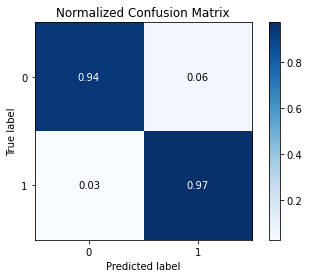

In [ ]:
print(metrics.classification_report(y_test, predictions, target_names=[ 'no-scarcity', 'scarcity']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()

skplt.metrics.plot_confusion_matrix(y_test, predictions , normalize=True)
plt.show()

In [ ]:
####################################################################################################################

Accuracy: 95.48%
              precision    recall  f1-score   support

 no-scarcity       0.96      0.95      0.95      2490
    scarcity       0.95      0.96      0.95      2490

    accuracy                           0.95      4980
   macro avg       0.95      0.95      0.95      4980
weighted avg       0.95      0.95      0.95      4980

confusion matrix:
[[2375  115]
 [ 110 2380]]



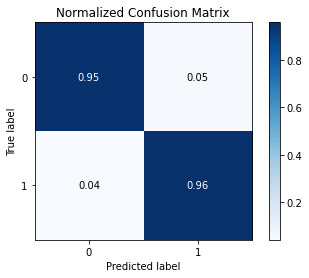

In [ ]:
save = pd.read_csv('data/revised/test_scarcity_4k.csv')
save=save.sample(frac=1)

save['ad'] = save['ad'].str.strip().str.lower() 

# Expand contractions 
save['ad'] = save['ad'].apply(lambda x:expand_contractions(x))

# Remove ponctuation 
save['ad'] =  save['ad'].str.translate(str.maketrans('','',string.punctuation))


norm_ = save['ad']
test_ = t.texts_to_sequences(norm_)
padded_ = tf.keras.preprocessing.sequence.pad_sequences(test_, maxlen=MAX_SEQUENCE_LENGTH)

pred_ = model.predict(padded_)
save['predicted'] = [1 if prob > 0.5 else 0 for prob in pred_]

scores = model.evaluate(padded_, save['scarcity'], verbose =False)
print("Accuracy: %.2f%%" % (scores[1]*100))
print(metrics.classification_report(save['scarcity'], save['predicted'], target_names=[ 'no-scarcity', 'scarcity']))
print("confusion matrix:")
print(metrics.confusion_matrix(save['scarcity'], save['predicted']))
print()

skplt.metrics.plot_confusion_matrix(save['scarcity'], save['predicted'], normalize=True)
plt.show()

Accuracy: 82.54%
confusion matrix:
[[46 12]
 [10 58]]



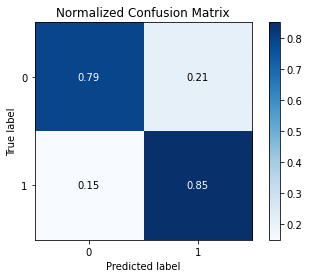

In [ ]:
save = pd.read_csv('data/sample_130.csv')
save=save.sample(frac=1)
save.drop_duplicates(subset ="ad",
                     keep = "first", inplace = True)

save['ad'] = save['ad'].str.strip().str.lower() 

# Expand contractions 
save['ad'] = save['ad'].apply(lambda x:expand_contractions(x))

# Remove ponctuation 
save['ad'] =  save['ad'].str.translate(str.maketrans('','',string.punctuation))


norm_ = save['ad']
test_ = t.texts_to_sequences(norm_)
padded_ = tf.keras.preprocessing.sequence.pad_sequences(test_, maxlen=MAX_SEQUENCE_LENGTH)

pred_ = model.predict(padded_)
save['predicted'] = [1 if prob > 0.5 else 0 for prob in pred_]

scores = model.evaluate(padded_, save['scarcity'], verbose =False)
print("Accuracy: %.2f%%" % (scores[1]*100))

print("confusion matrix:")
print(metrics.confusion_matrix(save['scarcity'], save['predicted']))
print()

skplt.metrics.plot_confusion_matrix(save['scarcity'], save['predicted'], normalize=True)
plt.show()

In [ ]:
print(metrics.classification_report(save['scarcity'],save['predicted'], target_names=[ 'no-scarcity', 'scarcity']))

              precision    recall  f1-score   support

 no-scarcity       0.82      0.79      0.81        58
    scarcity       0.83      0.85      0.84        68

    accuracy                           0.83       126
   macro avg       0.82      0.82      0.82       126
weighted avg       0.83      0.83      0.83       126

